In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Define column names
column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 27)]
train_df = pd.read_csv('./dataset/train_FD001.txt', sep='\s+', header=None, names=column_names)
test_df = pd.read_csv('./dataset/test_FD001.txt', sep='\s+', header=None, names=column_names)
true_rul = pd.read_csv('./dataset/RUL_FD001.txt', header=None)

In [8]:
# Dropping Columns
columns_to_drop = ["setting1", "setting2", "setting3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor22", "sensor23", "sensor24", "sensor25", "sensor26"]
train_df_dropped = train_df.drop(columns=columns_to_drop)
test_df_dropped = test_df.drop(columns=columns_to_drop)

In [20]:
# Normalization
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Separate the columns to normalize and the columns to skip
columns_to_skip = train_df_dropped.columns[:2]
columns_to_normalize = train_df_dropped.columns[2:]

# Normalize only the selected columns
normalized_data = scaler.fit_transform(train_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
train_df_normalized = pd.DataFrame(train_df_dropped[columns_to_skip].values, columns=columns_to_skip)
train_df_normalized = pd.concat([train_df_normalized, pd.DataFrame(normalized_data, columns=columns_to_normalize)], axis=1)

# Normalize the test data
test_normalized_data = scaler.transform(test_df_dropped[columns_to_normalize])

# Combine the normalized and unnormalized columns
test_df_normalized = pd.DataFrame(test_df_dropped[columns_to_skip].values, columns=columns_to_skip)
test_df_normalized = pd.concat([test_df_normalized, pd.DataFrame(test_normalized_data, columns=columns_to_normalize)], axis=1)

# Display the normalized DataFrame
print("Normalized Data (0-1 range):")
print(train_df_normalized.head())

Normalized Data (0-1 range):
   engine_id  cycle   sensor2   sensor3   sensor4   sensor7   sensor8  \
0          1      1  0.183735  0.406802  0.309757  0.726248  0.242424   
1          1      2  0.283133  0.453019  0.352633  0.628019  0.212121   
2          1      3  0.343373  0.369523  0.370527  0.710145  0.272727   
3          1      4  0.343373  0.256159  0.331195  0.740741  0.318182   
4          1      5  0.349398  0.257467  0.404625  0.668277  0.242424   

    sensor9  sensor11  sensor12  sensor13  sensor14  sensor15  sensor17  \
0  0.109755  0.369048  0.633262  0.205882  0.199608  0.363986  0.333333   
1  0.100242  0.380952  0.765458  0.279412  0.162813  0.411312  0.333333   
2  0.140043  0.250000  0.795309  0.220588  0.171793  0.357445  0.166667   
3  0.124518  0.166667  0.889126  0.294118  0.174889  0.166603  0.333333   
4  0.149960  0.255952  0.746269  0.235294  0.174734  0.402078  0.416667   

   sensor20  sensor21  
0  0.713178  0.724662  
1  0.666667  0.731014  
2  0.6279

In [10]:
# Labelling of Data with RUL and Piecewise
# 1) Labelling RUL
train_df_normalized['RUL'] = train_df_normalized.groupby('engine_id')['cycle'].transform(lambda x: x.max() - x)

# 2) Labelling PWRUL
# Set the early RUL threshold
early_rul_threshold = 120

# Define the piecewise linear degradation function
def piecewise_rul(cycle, max_cycle):
    remaining_life = max_cycle - cycle
    if remaining_life > early_rul_threshold:
        return early_rul_threshold  # slower degradation in the early phase
    else:
        return remaining_life  # direct linear degradation after threshold
    
train_df_normalized["PWRUL"] = train_df_normalized.apply(lambda row: piecewise_rul(row['cycle'], row['cycle'] + row['RUL']), axis=1)

In [11]:
# Prepping training data
sequence_length = 30

# Identify feature columns
feature_columns = [col for col in train_df_normalized.columns if col not in ['engine_id', 'cycle', 'RUL', 'PWRUL']]

# Initialize lists for sequences and labels
X = []
y = []

# Generate sequences and labels
for engine_id in train_df_normalized['engine_id'].unique():
    engine_data = train_df_normalized[train_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    for i in range(sequence_length, len(engine_data)):
        # Extract sequence of sensor readings
        seq_x = engine_data[feature_columns].iloc[i-sequence_length:i].values
        # Extract the RUL value at the end of the sequence
        seq_y = engine_data['PWRUL'].iloc[i]
        X.append(seq_x)
        y.append(seq_y)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print("Input shape:", X.shape)
print("Labels shape:", y.shape)

Input shape: (17631, 30, 14)
Labels shape: (17631,)


In [30]:
# CNN-LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional


# LSTM

In [19]:
# LSTM
lstm_model = Sequential()

# CNN layers for spatial feature extraction
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))  # Downsampling to reduce the sequence length
lstm_model.add(Dropout(0.2))

# LSTM layers for temporal pattern recognition
lstm_model.add(LSTM(units=128, return_sequences=True, activation='tanh'))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=64, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=32, activation='tanh'))
lstm_model.add(Dropout(0.2))

# Fully connected layers
lstm_model.add(Dense(units=96, activation='relu'))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(units=128, activation='relu'))
lstm_model.add(BatchNormalization())

# Output layer
lstm_model.add(Dense(units=1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
print(lstm_model.summary())

# Training the Model
history = lstm_model.fit(X, y, 
                         epochs=50, 
                         batch_size=64)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 28, 64)            2752      
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 64)            0         
                                                                 
 lstm (LSTM)                 (None, 13, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0         
                                                      

# CNN-LSTM

In [26]:
# CNN-LSTM
# Define the model (CNN-LSTM)
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, len(feature_columns))))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(LSTM(units=100))
cnn_lstm_model.add(Dense(units=1))

# Compile the model
cnn_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

print(cnn_lstm_model.summary())

# Training the Model
history = cnn_lstm_model.fit(X, y, 
                    epochs=50, 
                    batch_size=64)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 28, 64)            2752      
                                                                 
 conv1d_6 (Conv1D)           (None, 26, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 64)           0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100)               66000     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 81,205
Trainable params: 81,205
Non-trainable params: 0
__________________________________________________

# Bi-LSTM

In [31]:
 # Define the model
bi_lstm_model = Sequential()

# Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True, activation='tanh'), input_shape=(sequence_length, len(feature_columns))))
bi_lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))
bi_lstm_model.add(Bidirectional(LSTM(units=32, activation='tanh')))

# Fully connected layers
bi_lstm_model.add(Dense(units=96, activation='relu'))
bi_lstm_model.add(Dense(units=128, activation='relu'))

# Output layer
bi_lstm_model.add(Dense(units=1))

# Compile the model
bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = bi_lstm_model.fit(X, y, 
                           epochs=5, 
                        #    validation_data=(processed_val_data, processed_val_targets),
                           batch_size=128, 
                           verbose=2)


Epoch 1/5
138/138 - 19s - loss: 2723.1099 - 19s/epoch - 137ms/step
Epoch 2/5
138/138 - 15s - loss: 1617.1251 - 15s/epoch - 108ms/step
Epoch 3/5
138/138 - 15s - loss: 1617.5178 - 15s/epoch - 110ms/step
Epoch 4/5
138/138 - 15s - loss: 1617.8330 - 15s/epoch - 109ms/step
Epoch 5/5
138/138 - 15s - loss: 1449.3412 - 15s/epoch - 110ms/step


In [21]:
# Prepping test data
X_test = []
y_test = []

for engine_id in test_df_normalized['engine_id'].unique():
    engine_data = test_df_normalized[test_df_normalized['engine_id'] == engine_id].reset_index(drop=True)
    if len(engine_data) >= sequence_length:
        # Use only the last sequence
        seq_x = engine_data[feature_columns].iloc[-sequence_length:].values
        X_test.append(seq_x)
        # Get the true RUL for this engine
        seq_y = true_rul.loc[engine_id - 1].values[0]
        y_test.append(seq_y)
    else:
        print(f"Engine {engine_id} has insufficient data for the defined sequence length.")

X_test = np.array(X_test)
y_test = np.array(y_test)

# Testing Models

In [23]:
from sklearn.metrics import mean_squared_error

## LSTM

In [33]:
y_test_pred = lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse

4/4 [==============================] - 0s 5ms/step


16.798805064393452

4/4 [==============================] - 0s 5ms/step


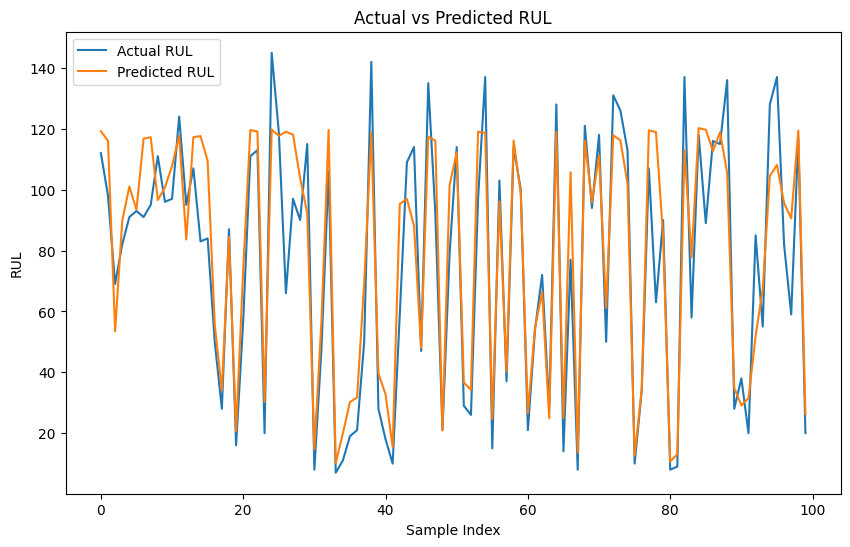

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Bi-LSTM

In [36]:
y_test_pred = bi_lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse

4/4 [==============================] - 0s 9ms/step


36.36237408779623

4/4 [==============================] - 0s 11ms/step


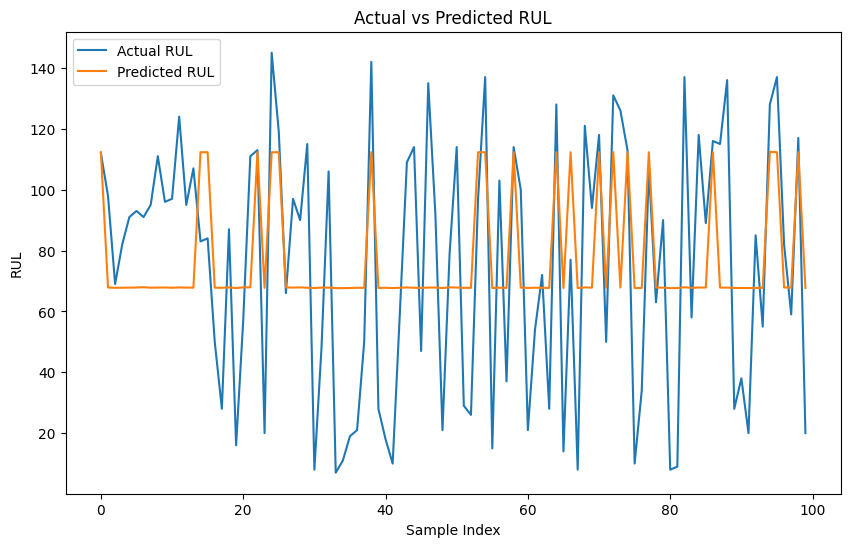

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(bi_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# CNN-LSTM

In [39]:
y_test_pred = cnn_lstm_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
rmse

4/4 [==============================] - 0s 2ms/step


14.187102333378048

4/4 [==============================] - 0s 2ms/step


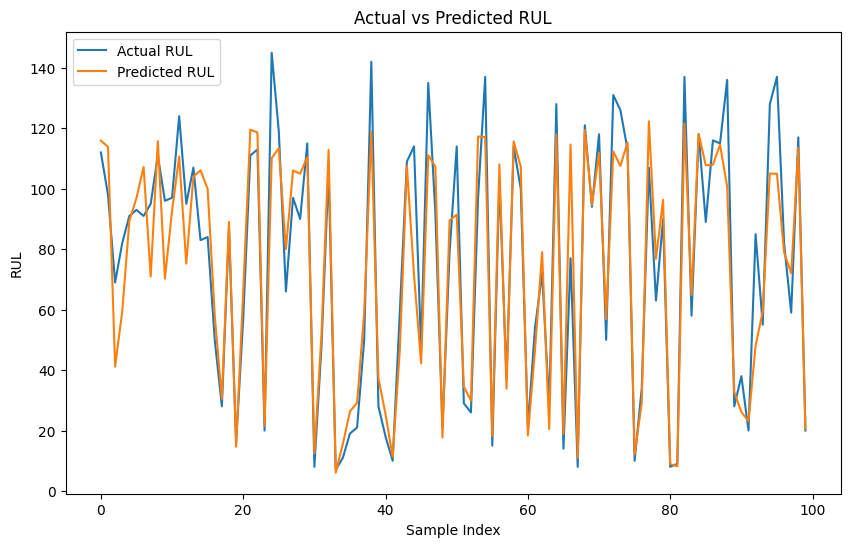

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(true_rul, label='Actual RUL')
plt.plot(cnn_lstm_model.predict(X_test), label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.show()

# Saving of Models

In [41]:
# MinMaxScaler
import pickle
with open('minmax_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [42]:
# Saving LSTM Model
lstm_model.save('lstm_model.h5')

In [43]:
# Saving Bi-LSTM Model
bi_lstm_model.save('bi_lstm_model.h5')

In [44]:
# Saving CNN-lstm Model
cnn_lstm_model.save('cnn_lstm_model.h5')